# Project 1
## The Net Wars: Attack of the Bots
### Advanced Machine Learning - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# Just to make plots look better
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 3

|Class  |Label |
| ----- | ---- | 
|Normal	|0     |
|Dos	|1     |
|R2L	|2     |
|U2R	|3     |
|Probe	|4     |

In [89]:
PATH_TO_DATA = 'dataset/'

test_students = pd.read_csv(PATH_TO_DATA + 'test_students.csv')
SampleID = test_students['SampleID']

train_students = pd.read_csv(PATH_TO_DATA + 'train_students.csv')


In [90]:
test_students = test_students.drop('SampleID', axis=1)

### Check Nulls and DataType

In [91]:
print(test_students.info())
print(train_students.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44556 entries, 0 to 44555
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     44556 non-null  int64  
 1   protocol_type                44556 non-null  object 
 2   service                      44556 non-null  object 
 3   flag                         44556 non-null  object 
 4   src_bytes                    44556 non-null  int64  
 5   dst_bytes                    44556 non-null  int64  
 6   land                         44556 non-null  int64  
 7   wrong_fragment               44556 non-null  int64  
 8   urgent                       44556 non-null  int64  
 9   hot                          44556 non-null  int64  
 10  num_failed_logins            44556 non-null  int64  
 11  logged_in                    44556 non-null  int64  
 12  num_compromised              44556 non-null  int64  
 13  root_shell      

### Correct possible outliers

In [92]:
#Service não contêm o mesmo número de valores
train_students = train_students.drop('service', axis=1)
test_students = test_students.drop('service', axis=1)

#Valores com 75% de 0 sendo que a média é baixa ou perto de 0

train_students = train_students.drop('hot', axis=1)
test_students = test_students.drop('hot', axis=1)

train_students = train_students.drop('num_compromised', axis=1)
test_students = test_students.drop('num_compromised', axis=1)

train_students = train_students.drop('num_root', axis=1)
test_students = test_students.drop('num_root', axis=1)

train_students = train_students.drop('num_file_creations', axis=1)
test_students = test_students.drop('num_file_creations', axis=1)

<AxesSubplot:>

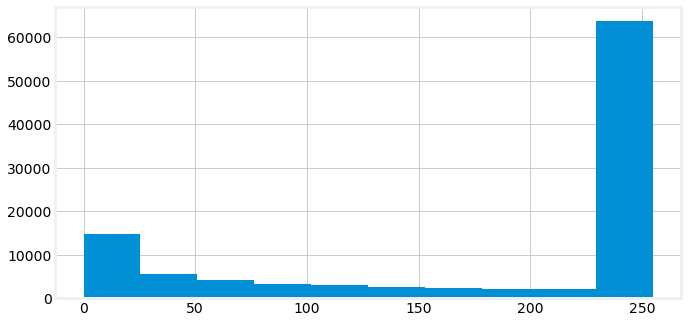

In [93]:
num_ts = train_students.select_dtypes(include=np.number)

train_students[num_ts.columns[24]].hist()

As features não são seguem uma distribuição normal. Deste modo, o melhor método para detetar outliers é o IQR

In [94]:
'''
k = 1.5 #limiar habitual

for c in num_ts.columns:
    k = 1.5
    quantil = train_students[c].quantile([0.25,0.75])
    iqr = quantil[0.75] - quantil[0.25]
    limite = [quantil[0.25] - k*iqr, quantil[0.75] + k*iqr]

    train_students.loc[(train_students[c] < limite[0]) | (train_students[c] > limite[1]), c] = train_students[c].mean()
'''

'\nk = 1.5 #limiar habitual\n\nfor c in num_ts.columns:\n    k = 1.5\n    quantil = train_students[c].quantile([0.25,0.75])\n    iqr = quantil[0.75] - quantil[0.25]\n    limite = [quantil[0.25] - k*iqr, quantil[0.75] + k*iqr]\n\n    train_students.loc[(train_students[c] < limite[0]) | (train_students[c] > limite[1]), c] = train_students[c].mean()\n'

In [95]:
# TO SEE IF WE CONTINUE TO HAVE OUTLIERS
'''
for c in num_ts.columns:
    asc = train_students[c].sort_values()   #coluna por ordem ascendente
    qs = asc.quantile([0.25, 0.75])
    iqr = qs[0.75] - qs[0.25]

    print(len(train_students.loc[train_students[c] < (qs[0.25] - (k * iqr)), c]))
    print(len(train_students.loc[train_students[c] > (qs[0.75] + (k * iqr)), c]))
'''
train_students.describe()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,num_failed_logins,logged_in,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,103961.000000,1.039610e+05,1.039610e+05,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,...,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000
mean,275.173796,3.973167e+04,2.306635e+04,0.000164,0.020460,0.000173,0.004232,0.402593,0.001491,0.000933,...,183.771857,119.597243,0.535200,0.084182,0.146056,0.030645,0.255452,0.250485,0.137248,0.137525
std,2447.626055,5.776657e+06,4.426298e+06,0.012787,0.239667,0.017544,0.071813,0.490423,0.038584,0.041484,...,98.605667,111.244045,0.448242,0.194313,0.308700,0.108958,0.428060,0.429276,0.323793,0.336550
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,86.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.800000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.010000,0.550000,0.490000,0.000000,0.000000
max,54451.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,2.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalization

In [96]:
'''
display(train_students)

for c in num_ts.columns:
    minV = train_students[c].min()
    maxV = train_students[c].max()
    train_students[c] = (train_students[c] - minV) / (maxV - minV)

display(train_students)
'''

'\ndisplay(train_students)\n\nfor c in num_ts.columns:\n    minV = train_students[c].min()\n    maxV = train_students[c].max()\n    train_students[c] = (train_students[c] - minV) / (maxV - minV)\n\ndisplay(train_students)\n'

In [97]:
'''
display(test_students)

for c in num_ts.columns:
    minV = test_students[c].min()
    maxV = test_students[c].max()
    test_students[c] = (test_students[c] - minV) / (maxV - minV)

display(test_students)
'''

'\ndisplay(test_students)\n\nfor c in num_ts.columns:\n    minV = test_students[c].min()\n    maxV = test_students[c].max()\n    test_students[c] = (test_students[c] - minV) / (maxV - minV)\n\ndisplay(test_students)\n'

Categoric features

O service do train_students tem mais um tipo que no test_students. 

In [98]:
train_students = pd.get_dummies(train_students, columns=['protocol_type'], drop_first=True)
#train_students = train_students.drop('service', axis=1)
#train_students = pd.get_dummies(train_students, columns=['service'], drop_first=True)
train_students= pd.get_dummies(train_students, columns=['flag'], drop_first=True)

test_students = pd.get_dummies(test_students, columns=['protocol_type'], drop_first=True)
#test_students = test_students.drop('service', axis=1)
#test_students = pd.get_dummies(test_students, columns=['service'], drop_first=True)
test_students= pd.get_dummies(test_students, columns=['flag'], drop_first=True)



In [99]:
train_students.replace('normal', 0, inplace=True)
train_students.replace('Dos', 1, inplace=True)
train_students.replace('R2L', 2, inplace=True)
train_students.replace('U2R', 3, inplace=True)
train_students.replace('Probe', 4, inplace=True)


In [100]:
y_train = train_students['attack_type']
X_train = train_students.drop(columns=['attack_type'], axis=1)

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Ensembles

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

voting = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('kn', knn), 
        ('dt', dt), 
        ('rf', rf)
    ],
    voting='soft'
)

ensemble = GridSearchCV(
    voting,
    {},
    scoring=['accuracy', 'precision', 'recall', 'f1_micro'],
    refit='accuracy',
    cv=5
)

ensemble.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(max_iter=1000)),
                                                    ('kn',
                                                     KNeighborsClassifier()),
                                                    ('dt',
                                                     DecisionTreeClassifier()),
                                                    ('rf',
                                                     RandomForestClassifier())],
                                        voting='soft'),
             param_grid={}, refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1_micro'])

In [103]:
lista_classifiers = [('LogisticRegression', lr), ('KNeighborsClassifier', knn), ('DecisionTreeClassifier', dt), ('RandomForestClassifier', rf), ('VotingClassifier', voting), ]

### Classification Report de todos os modelos

In [104]:
from sklearn.metrics import classification_report

for name, model in lista_classifiers:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    print('=========================================')

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     10791
           1       0.77      0.89      0.83      7461
           2       0.00      0.00      0.00       537
           3       0.00      0.00      0.00        17
           4       0.60      0.04      0.07      1987

    accuracy                           0.80     20793
   macro avg       0.44      0.37      0.35     20793
weighted avg       0.76      0.80      0.76     20793

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10791
           1       0.99      1.00      0.99      7461
           2       0.90      0.91      0.91       537
           3       0.33      0.12      0.17        17
           4       0.96      0.93      0.94      1987

    accuracy                           0.98     20793
   macro avg       0.83      0.79      0.80     20793
weighted avg       0.98      0.98      0.98     20793

              precisio

In [106]:
ensemble.

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('kn', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

### Só melhor modelo

In [105]:
pred = ensemble.predict(test_students)

submission = pd.DataFrame({'SampleID': SampleID, 'Class': pred})
print(submission)
submission.to_csv('submission_ensembles_dropColumns.csv', index=False)

       SampleID  Class
0             0      0
1             1      0
2             2      0
3             3      0
4             4      1
...         ...    ...
44551     44551      0
44552     44552      1
44553     44553      1
44554     44554      0
44555     44555      0

[44556 rows x 2 columns]
